In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 120 kB 69.6 MB/s 
     |████████████████████████████████| 6.6 MB 48.9 MB/s 


In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np

import transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig

from keras.preprocessing.sequence import pad_sequences

from tqdm.notebook import tqdm
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data = '/content/drive/MyDrive/Colab Notebooks/deeplearning_news_clustering/data/allData-19-08-27.ta'
df = pd.read_csv(data, header=None, names=['news'])
df.head(), len(df)

,news
0,அமைச்சின் பணிகளை முன்னெடுப்பதற்கு கௌர அமைச்சர்...
1,இவ்வமைச்சு இல 40 புத்கமுவ வீதி இராஜகிரிய எனு...
2,தேசிய மொழிகள் மற்றும் சமூக ஒருமைப்பாட்டு அமைச்...
3,தேசிய மொழிகள் சமூக ஒருமைப்பாடு தொடர்பான கொள்...
4,குறித்த தேசிய நோக்கங்களை எய்தும் பொருட்டு தேச...


## BERT Input Length Limitation

In [8]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Checking how tokenizer working

In [9]:
news = df.iloc[1].news

# Run the tokenizer to count up the number of tokens. The tokenizer will split
# the text into words, punctuation, and subwords as needed. 
tokens = tokenizer.tokenize(news)

print('1st news {:,} WordPiece tokens.'.format(len(tokens)))
print('\n==== Original news: ====\n')
print(news)

print('\n==== Tokens: ====\n')
print(str(' '.join(tokens)))

1st news 32 WordPiece tokens.

==== Original news: ====

இவ்வமைச்சு இல 40  புத்கமுவ வீதி  இராஜகிரிய எனும் முகவரியில் அமையப்பெற்றுள்ளது 

==== Tokens: ====

இ ##வ ##வம ##ை ##சசு இல 40 ப ##ு ##த ##கம ##ு ##வ வ ##தி இ ##ர ##ா ##ஜ ##கி ##ரிய எனும மு ##க ##வர ##ியில அ ##மை ##ய ##ப ##பெறற ##ுளளது


In [11]:
# Tokenize all of the tweets and map the tokens to their word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

# class of the tweets
labels = []

print('Tokenizing news...')

# For every tweet...
for index, row in df.iterrows():
  news = row['news']

  # Report progress.
  if ((len(input_ids) % 50000) == 0):
    print('Read {:,} news.'.format(len(input_ids)))
  
  tokens = tokenizer.tokenize(news)
  if (len(tokens) > 510):
    tokens = tokens[:128] + tokens[-382:]

  if (len(tokens) > 0):
    # `encode` will:
    #   (1) Tokenize the tweet.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                      tokens,                     # Sentence to encode.
                      add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                      #max_length = 512,          # Truncate all sentences.                        
                      #return_tensors = 'pt',     # Return pytorch tensors.
                  )
    
    # Add the encoded tweets to the list.
    input_ids.append(encoded_sent)

    # Record the truncated length.
    lengths.append(len(encoded_sent))

    labels.append(row['news'])

print('{:>10,} news'.format(len(input_ids)))
print('DONE.')

Tokenizing news...
Read 0 news.
Read 50,000 news.
Read 100,000 news.
Read 150,000 news.
Read 200,000 news.
Read 250,000 news.
Read 300,000 news.
Read 350,000 news.
Read 400,000 news.
Read 450,000 news.
Read 500,000 news.
Read 550,000 news.
Read 600,000 news.
Read 650,000 news.
Read 700,000 news.
Read 750,000 news.
Read 800,000 news.
Read 850,000 news.
Read 900,000 news.
Read 950,000 news.
Read 1,000,000 news.
Read 1,050,000 news.
Read 1,100,000 news.
Read 1,150,000 news.
Read 1,200,000 news.
Read 1,250,000 news.
Read 1,300,000 news.
Read 1,350,000 news.
Read 1,400,000 news.
Read 1,450,000 news.
Read 1,500,000 news.
Read 1,550,000 news.
Read 1,600,000 news.
Read 1,650,000 news.
Read 1,700,000 news.
 1,727,888 news
DONE.


In [12]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 3 tokens
   Max length: 512 tokens
Median length: 38.0 tokens


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of news')

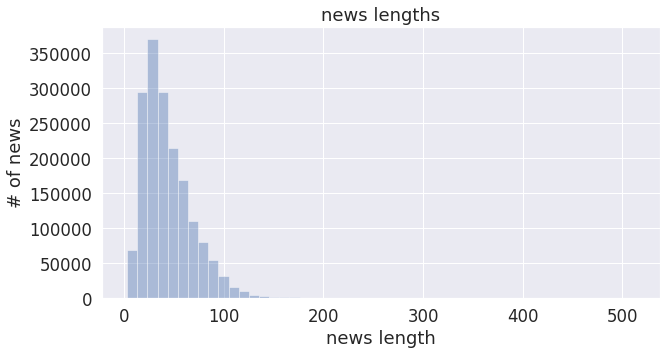

In [13]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any tweet lengths greater than 512.
#lengths = [min(l, 512) for l in lengths]

# Plot the distribution of tweet lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('news lengths')
plt.xlabel('news length')
plt.ylabel('# of news')

In [15]:
minpos = lengths.index(min(lengths))
maxpos = lengths.index(max(lengths))
lengths[minpos], lengths[maxpos]

(3, 512)

In [18]:
# Set the required sequence length.
MAX_LEN = 510

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 510 values...

Padding token: "[PAD]", ID: 0

Done.


**Attention Masks**

In [ ]:
# # Create attention masks
# attention_masks = []

# # For each tweets...
# for sent in input_ids:    
#   # Create the attention mask.
#   #   - If a token ID is 0, then it's padding, set the mask to 0.
#   #   - If a token ID is > 0, then it's a real token, set the mask to 1.
#   att_mask = [int(token_id > 0) for token_id in sent]
  
#   # Store the attention mask for this sentence.
#   attention_masks.append(att_mask)

## Build model

In [56]:
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = TFBertModel.from_pretrained('bert-base-multilingual-uncased')

# model = transformers.TFBertModel.from_pretrained('bert-base-multilingual-uncased')

# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
# model = transformers.TFBertModel.from_pretrained('bert-base-multilingual-uncased')

# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased')

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [61]:
MAX_LEN = 512

def get_embeddings(news):
  # tokens = tokenizer.tokenize(news)
  
  # if (len(tokens) > 510):
  #   tokens = tokens[:128] + tokens[-382:]
  
  # input_ids = tokenizer.encode(
  #               tokens,                     # Sentence to encode.
  #               add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
  #               max_length = 512,           # Truncate all sentences.
  #               truncation=True,
  #               pad_to_max_length=True
  #             )

  input_ids = tf.constant(tokenizer.encode_plus(
    news, 
    add_special_tokens = True, 
    max_length = 512, 
    truncation = True, 
    padding = "max_length"
  ))[None, :]

  print('1')
  outputs = model(input_ids)
  print('2')  
  last_hidden_states = outputs[0]
  print('3')  
  cls_token = last_hidden_states[0]
  print('4')
  return cls_token

In [62]:
embeddings = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
  print("row", row['news'])
  vec = get_embeddings(row['news'])
  break
  # vec = get_embeddings(row['news'])
  # embeddings.append(vec)

  0%|          | 0/1727888 [00:00<?, ?it/s]

row அமைச்சின் பணிகளை முன்னெடுப்பதற்கு கௌர அமைச்சர் வாசுதேவ நாணாயக்கார அவர்களுக்கு தத்துவம் வழங்கப்பட்டதுடன் திருமதி எம்  எஸ்  விக்கிரமசிங்க அமைச்சின் செயலாளராக செயலாற்றுகிறார் 
1


InvalidArgumentError: ignored